In [7]:
###############
## FUNCTIONS ##
###############

def normalise(img):
    img_new = np.copy(img).astype(float)  # Ensure image is float for normalization
    num_channels = img_new.shape[2]
    for c in range(num_channels):
        channel = img_new[:, :, c]
        min_val = channel.min()
        max_val = channel.max()
        if max_val > min_val:  # Avoid division by zero
            img_new[:, :, c] = (channel - min_val) / (max_val - min_val)
        else:
            img_new[:, :, c] = 0  # Set to 0 if channel is flat
    return (img_new * 255).astype(np.uint8)  # Scale back to [0, 255]

def apply_clahe(img, clip_limit=2.0, tile_grid_size=(8, 8)):
    """
    Apply CLAHE to enhance contrast in the image.
    
    Parameters:
    - img: Input image (RGB or grayscale).
    - clip_limit: Threshold for contrast limiting.
    - tile_grid_size: Size of the grid for CLAHE.
    
    Returns:
    - Image with CLAHE applied.
    """
    ## Convert to grayscale if the image is RGB
    if len(img.shape) == 3 and img.shape[2] == 3:  # Check if RGB
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray_img = img  # Already grayscale
    
    ## Create CLAHE object
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    
    ## Apply CLAHE
    clahe_img = clahe.apply(gray_img)
    
    return clahe_img


def load_images_from_path(path):
    """
    Goal: Load images from path.
    Args: 
    - path (str): Path to folder containing images.
    Outputs:
    - imgs (list(np.array)): The images.
    - fnames (list(str)): The names of the images.
    """
    imgs = []
    fnames = []
    for f in os.listdir(path):        
        if f[0] != ".":
            # print("Loading " + f)
            img_bgr = cv2.imread(path + f)
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            imgs += [img_rgb]
            fnames += [f]
    return imgs, fnames

def load_masks_from_path(path):
    """
    Goal: Load masks from path.
    Args: 
    - path (str): Path to folder containing images.
    Outputs:
    - imgs (list(np.array)): The images.
    - fnames (list(str)): The names of the images.
    """
    masks = []
    fnames = []
    for f in os.listdir(path):        
        if f[0] != ".":
            # print("Loading " + f)
            mask = cv2.imread(path + f)            
            masks += [mask]
            fnames += [f]
    return masks, fnames

def show_image(img, fig_size):
    """
    Goal: Wrapper function to quickly visualise images.
    Args:
    - img (np.array): image.
    """ 
    fig = plt.figure(figsize=(fig_size,fig_size))
    plt.imshow(img)
    plt.tight_layout()
    plt.show()
    plt.close()

def orient_object_pca(image, mask):
    """
    Goal: Orient object horizontally.
    Inputs:
    image (np.array): Image to orient.
    mask (np.array): Binary mask of the target object of the same dimension as the image.
    Outputs:
    rotate (np.array): The rotate image.
    """    
    ## Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    ## Filter out small contours based on area
    contours = [contour for contour in contours if cv2.contourArea(contour) > 500]
    
    if not contours:
        print("No significant contours found!")
        return image
    
    ## Assume the largest contour is the fish
    largest_contour = max(contours, key=cv2.contourArea)
    
    ## Compute the centroid of the fish
    moments = cv2.moments(largest_contour)
    if moments['m00'] == 0:  # To avoid division by zero
        return image
    
    ## Calculate the centroid (cx, cy)
    cx = int(moments['m10'] / moments['m00'])
    cy = int(moments['m01'] / moments['m00'])
    
    ## Perform PCA on the contour points
    contour_points = largest_contour.reshape(-1, 2).astype(np.float32)
    mean, eigenvectors = cv2.PCACompute(contour_points, mean=np.array([]))
    
    ## The angle of the first principal component
    angle = np.arctan2(eigenvectors[0, 1], eigenvectors[0, 0]) * 180 / np.pi
    
    ## Rotate the image to align the fish horizontally
    (h, w) = image.shape[:2]
    center = (cx, cy)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    
    return rotated


#
###

In [2]:
##############
## INITIATE ##
##############

## Imports
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import torch

## Paths
PT_ROOT = '/Users/wargniez/Coding/guppy_project/'
PTI_IMAGES = PT_ROOT + 'data/images/'
PTI_MASKS_FIN = PT_ROOT + 'data/masks_caudal_fin/'
PTI_MASKS_BODY = PT_ROOT + 'data/masks_main_body/'
PTI_MASKS_EYE = PT_ROOT + 'data/masks_eye/'
PTI_MASKS_RULER = PT_ROOT + 'data/masks_ruler/'
PTO = PT_ROOT + 'outputs/handcrafted_features/'

## Check if path to output exists
if not os.path.exists(PTO):
    os.mkdir(PTO)

#
###

In [ ]:
#################
## LOAD IMAGES ##
#################

## Path 
imgs, fnames = load_images_from_path(PTI_IMAGES)

## Check that images are horizontal
imgs_new = []
for img in imgs:
    if img.shape[0] > img.shape[1]:
        img_new = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    else:
        img_new = img
    imgs_new += [img_new]
imgs = imgs_new
        
#
###

################
## LOAD MASKS ##
################

## Get masks
masks_fin, fnames_masks = load_masks_from_path(PTI_MASKS_FIN)
masks_body, _ = load_masks_from_path(PTI_MASKS_BODY)
masks_eye, _ = load_masks_from_path(PTI_MASKS_EYE)
masks_ruler, _ = load_masks_from_path(PTI_MASKS_RULER)

#
###

######################################
## CHECK THAT IMAGES ARE HORIZONTAL ##
######################################

## Check that images are horizontal
imgs_new = []
masks_fin_new = []
masks_body_new = []
masks_eye_new = []
masks_ruler_new = []

for k, img in enumerate(imgs):
    if img.shape[0] > img.shape[1]:
        ## Rotate image
        img_new = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        
        ## Rotate corresponding masks
        mask_fin_new = cv2.rotate(masks_fin[k], cv2.ROTATE_90_CLOCKWISE)
        mask_body_new = cv2.rotate(masks_body[k], cv2.ROTATE_90_CLOCKWISE)
        mask_eye_new = cv2.rotate(masks_eye[k], cv2.ROTATE_90_CLOCKWISE)
        mask_ruler_new = cv2.rotate(masks_ruler[k], cv2.ROTATE_90_CLOCKWISE)
    else:
        ## Keep image and masks as is
        img_new = img
        mask_fin_new = masks_fin[k]
        mask_body_new = masks_body[k]
        mask_eye_new = masks_eye[k]
        mask_ruler_new = masks_ruler[k]
    
    ## Append updated images and masks
    imgs_new.append(img_new)
    masks_fin_new.append(mask_fin_new)
    masks_body_new.append(mask_body_new)
    masks_eye_new.append(mask_eye_new)
    masks_ruler_new.append(mask_ruler_new)

## Replace original lists with updated ones
imgs = imgs_new
masks_fin = masks_fin_new
masks_body = masks_body_new
masks_eye = masks_eye_new
masks_ruler = masks_ruler_new
#
###

In [ ]:
## FEATURE TABLE
FEATURES = [['FILE_NAME', 'LENGTH_CENTRE', 'WIDTH_CENTRE', 'LENGTH_MINMAX', 'WIDTH_MINMAX', 'FIN_AREA', 'BODY_AREA', 'EYE_AREA']]

## For each image and masks
for img_index in range(len(imgs)):
    
    ####################
    ## APPLY TO IMAGE ##
    ####################
    
    ## Select image and masks
    img = imgs[img_index]
    mask_fin = (masks_fin[img_index] > 100)
    mask_body = (masks_body[img_index] > 100)
    mask_eye = (masks_eye[img_index] > 100)
    mask_ruler = (masks_ruler[img_index] > 100)
    
    #
    ###
    
    ###################
    ## COMBINE MASKS ##
    ###################
    
    ## Compute combined masks
    h, w, c = img.shape
    masks = np.zeros((h, w, c))
    masks[:,:,0] = mask_fin[:,:,0]
    masks[:,:,1] = (mask_body[:,:,0])*1 - (mask_eye[:,:,0])*1 
    masks[:,:,2] = mask_eye[:,:,0]
    masks = masks.astype(np.uint8)
    
    #
    ###
    
    ##################
    ## ORIENT RULER ##
    ##################
    
    ## Image and mask
    image = (img * mask_ruler).astype(np.uint8)
    mask = (mask_ruler[:,:,0] * 255).astype(np.uint8)
    
    ## Orient the fish using PCA
    oriented_image_pca = orient_object_pca(image, mask)
    oriented_mask_pca = orient_object_pca(mask, mask)
    
    #
    ###
    
   ###################
    ## COMPUTE MMPPX ##
    ###################

    """ Old method
    ## Binarise ruler
    img_bin = ((normalise(oriented_image_pca)[:,:,0]>100)*1).astype(np.uint8)
    
    ## Compute strip of ruler
    idx_h = int(np.mean(np.where((img_bin.sum(1)>1) > 0.5))) ## Center of ruler along height axis
    idx_w = int(np.mean(np.where((img_bin.sum(0)>1) > 0.5))) ## Center of ruler along width axis
    img_bin_strip = img_bin[idx_h,idx_w-1000:idx_w+1000]
    
    ## Compute number of ticks
    length_in_mm = (np.diff(img_bin_strip)==1).sum()
    length_in_px = img_bin_strip.shape[0]
    mmppx = length_in_mm/length_in_px
    """

    ## Binarise ruler
    img_bin = apply_clahe(normalise(oriented_image_pca))
    # img_bin = ((apply_clahe(normalise(oriented_image_pca))>50)*1).astype(np.uint8)
    
    ## Compute strip of ruler
    idx_h = int(np.mean(np.where((img_bin.sum(1)>1) > 0.5))) ## Center of ruler along height axis
    idx_w = int(np.mean(np.where((img_bin.sum(0)>1) > 0.5))) ## Center of ruler along width axis
    # img_bin_strip = img_bin[idx_h,idx_w-1000:idx_w+1000]
    img_bin_marg = img_bin.sum(0) 
    img_bin_strip = (img_bin_marg < img_bin_marg.mean())[idx_w-1000:idx_w+1000]
    
    ## Compute number of ticks
    length_in_mm = (np.diff(img_bin_strip.astype(np.int16))==1).sum()
    length_in_px = img_bin_strip.shape[0]
    mmppx = length_in_mm/length_in_px
    
    #
    ###
    
    ##################
    ## ORIENT GUPPY ##
    ##################
    
    ## Image and mask
    image = (img * mask_body).astype(np.uint8)
    mask = (mask_body[:,:,0] * 255).astype(np.uint8)
    
    ## Orient the fish using PCA
    oriented_image_pca = orient_object_pca(image, mask)
    oriented_mask_pca = orient_object_pca(mask, mask)
    
    #
    ###
    
    #############################
    ## COMPUTE STANDARD LENGTH ##
    #############################
    
    ## Binarise image
    img_bin = ((oriented_mask_pca)>100)*1
    
    ## Compute strip of guppy
    idx_h = int(np.mean(np.where((img_bin.sum(1)>1) > 0.5))) ## Center of guppy along height axis
    # idx_w = int(np.mean(np.where((img_bin.sum(0)>1) > 0.5))) ## Center of guppy along width axis
    img_bin_strip = img_bin[idx_h]
    
    ## Compute left and right bound
    pts_in_fish = np.argwhere(img_bin_strip == 1)
    LB = np.min(pts_in_fish)
    RB = np.max(pts_in_fish)
    
    ## Compute standard length
    length_in_px = RB - LB
    length_in_mm = length_in_px * mmppx

    ## Store
    LENGTH_CENTRE = length_in_mm
    #
    ###
    
    ############################
    ## COMPUTE STANDARD WIDTH ##
    ############################
    
    ## Binarise image
    img_bin = ((oriented_mask_pca)>100)*1
    
    ## Compute strip of guppy
    # idx_h = int(np.mean(np.where((img_bin.sum(1)>1) > 0.5))) ## Center of guppy along height axis
    idx_w = int(np.mean(np.where((img_bin.sum(0)>1) > 0.5))) ## Center of guppy along width axis
    # img_bin_strip = img_bin[idx_h]
    img_bin_strip = img_bin[:,idx_w]
    
    ## Compute left and right bound
    pts_in_fish = np.argwhere(img_bin_strip == 1)
    LB = np.min(pts_in_fish)
    RB = np.max(pts_in_fish)
    
    ## Compute standard length
    width_in_px = RB - LB
    width_in_mm = width_in_px * mmppx

    ## Store
    WIDTH_CENTRE = width_in_mm
    
    #
    ###
    
    ###########################
    ## COMPUTE MINMAX LENGTH ##
    ###########################
    
    ## Binarise image
    img_bin = ((oriented_mask_pca)>100)*1
    
    ## Compute strip of guppy
    img_bin_strip = (img_bin.sum(0)>1)*1
    
    ## Compute left and right bound
    pts_in_fish = np.argwhere(img_bin_strip == 1)
    LB = np.min(pts_in_fish)
    RB = np.max(pts_in_fish)
    
    ## Compute standard length
    length_in_px = RB - LB
    length_in_mm = length_in_px * mmppx

    ## Store
    LENGTH_MINMAX = length_in_mm
    
    #
    ###
    
    ##########################
    ## COMPUTE MINMAX WIDTH ##
    ##########################
    
    ## Binarise image
    img_bin = ((oriented_mask_pca)>100)*1
    
    ## Compute strip of guppy
    img_bin_strip = (img_bin.sum(1)>1)*1
    
    ## Compute left and right bound
    pts_in_fish = np.argwhere(img_bin_strip == 1)
    LB = np.min(pts_in_fish)
    RB = np.max(pts_in_fish)
    
    ## Compute standard length
    width_in_px = RB - LB
    width_in_mm = width_in_px * mmppx
    
    ## Store
    WIDTH_MINMAX = width_in_mm
    
    #
    ###
    
    ##################
    ## COMPUTE AREA ##
    ##################
    
    ## Areas
    fin_area, body_area, eye_area = masks.sum((0,1)) * mmppx ** 2

    ## STORE
    FIN_AREA = fin_area
    BODY_AREA = body_area
    EYE_AREA = eye_area
    
    #
    ###

    #############
    ## COLLECT ##
    #############

    FEATURES_ = [fnames[img_index], LENGTH_CENTRE, WIDTH_CENTRE, LENGTH_MINMAX, WIDTH_MINMAX, FIN_AREA, BODY_AREA, EYE_AREA]
    FEATURES += [FEATURES_]

    #
    ###

In [5]:
##################
## END AND SAVE ##
##################

## Save table
np.savetxt(PTO + 'phenotypes.csv', FEATURES, fmt='%s', delimiter=',')

#
###

Merge output csv metadata with features and merge with sex 

In [ ]:
import pandas as pd
import os 

# load csv files
phenotype_df = pd.read_csv("/Users/wargniez/Coding/guppy_project/outputs/handcrafted_features/phenotypes.csv")
sex_df = pd.read_csv("/Users/wargniez/Coding/guppy_project/data/metadata/metadata_sex.csv")

# Ensure the 'file_name' column exists in both DataFrames and change ot match 
phenotype_df.rename(columns={"FILE_NAME": "file_name"}, inplace=True)

phenotype_df['file_name'] = phenotype_df['file_name'].apply(lambda x: os.path.splitext(x)[0])
sex_df['file_name'] = sex_df['file_name'].apply(lambda x: os.path.splitext(x)[0])

# Merge the DataFrames on the 'file_name' column
features_df = pd.merge(phenotype_df, sex_df, on="file_name", how="inner")  

# Display or save the merged DataFrame
print(features_df)
features_df.to_csv("/Users/wargniez/Coding/guppy_project/outputs/handcrafted_features/features_data.csv", index=False)

# Descriptive Statistics 
Plot Data to understand features 

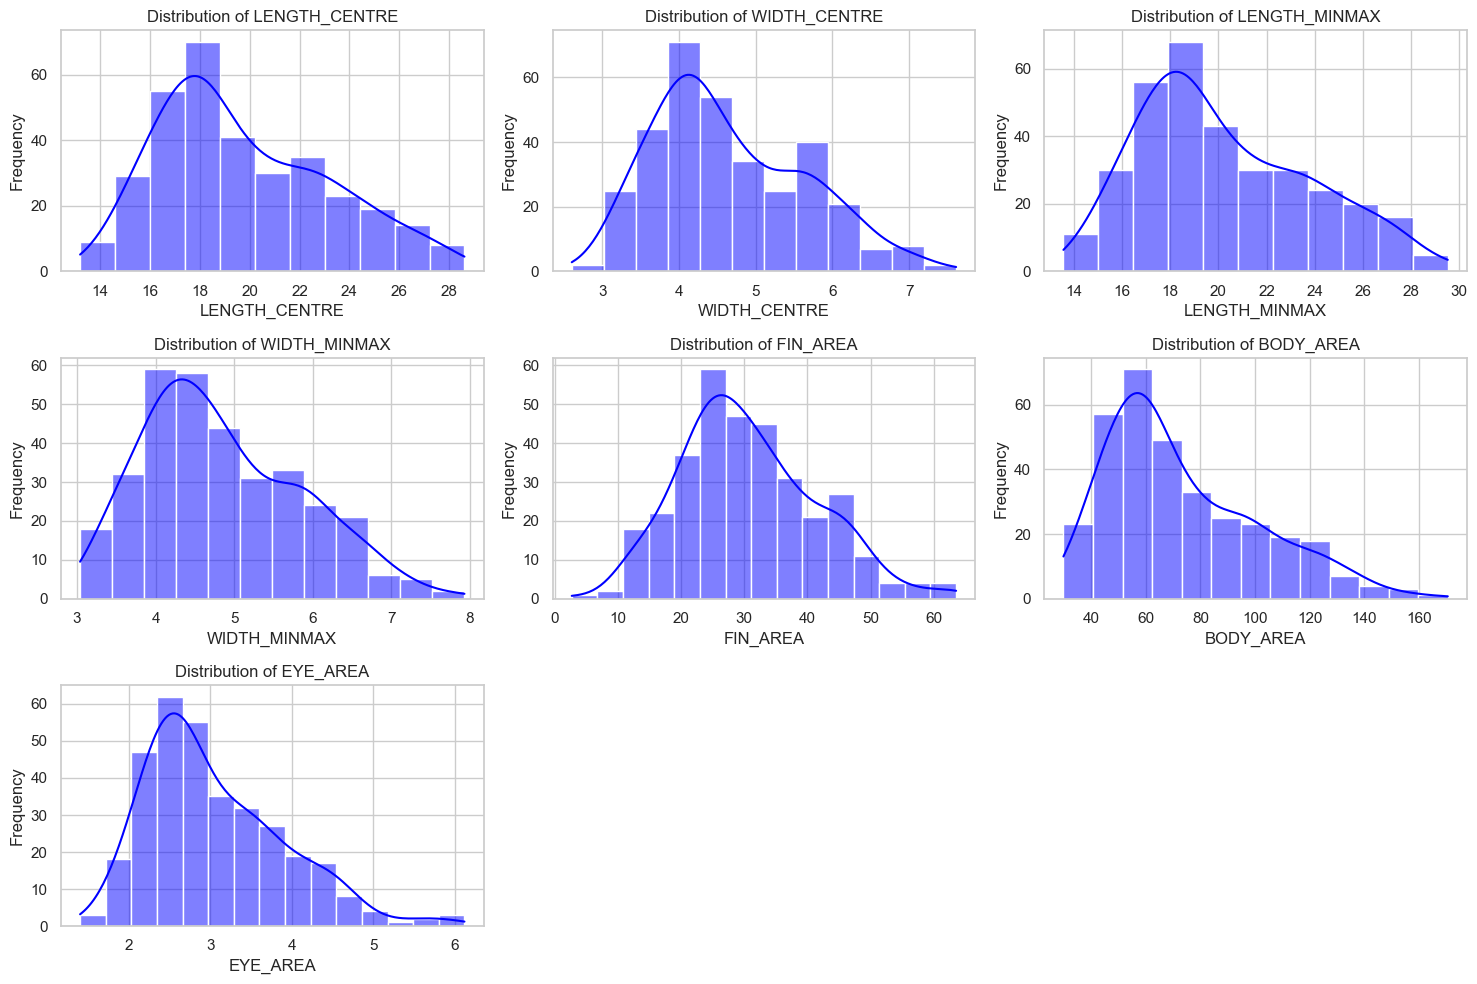

In [ ]:
# Set up the plot style
sns.set(style="whitegrid")

# Plot all numerical features
numerical_columns = ['LENGTH_CENTRE', 'WIDTH_CENTRE', 'LENGTH_MINMAX', 'WIDTH_MINMAX', 'FIN_AREA', 'BODY_AREA', 'EYE_AREA']

# Create subplots
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(features_df[column], kde=True, color="blue")
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()



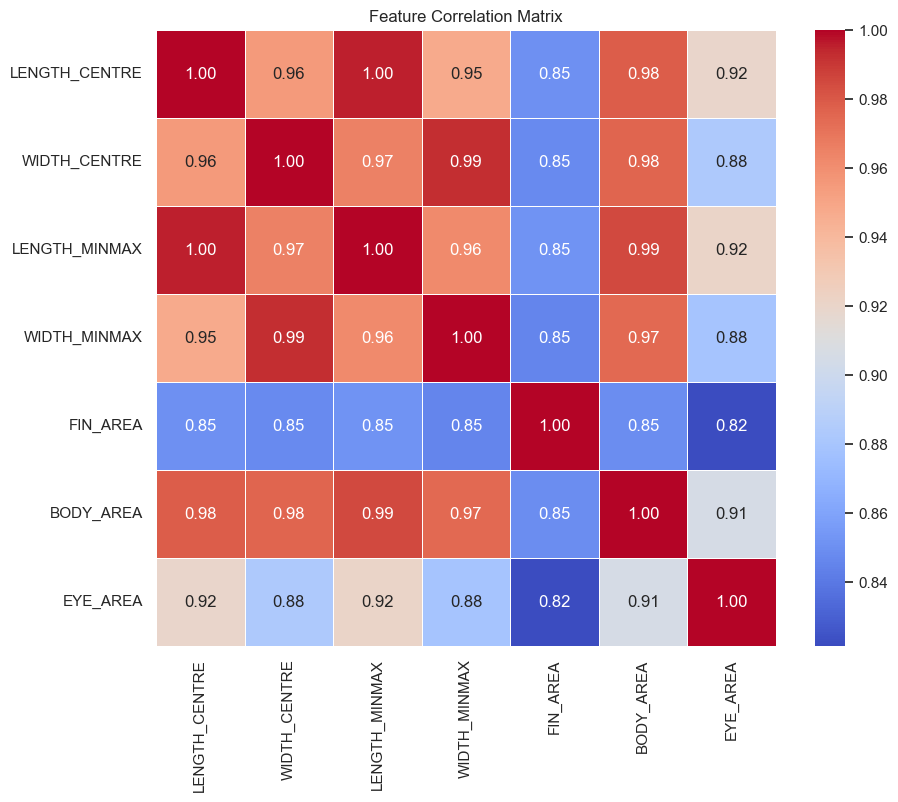

In [23]:
plt.figure(figsize=(10, 8))
correlation_matrix = features_df[numerical_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

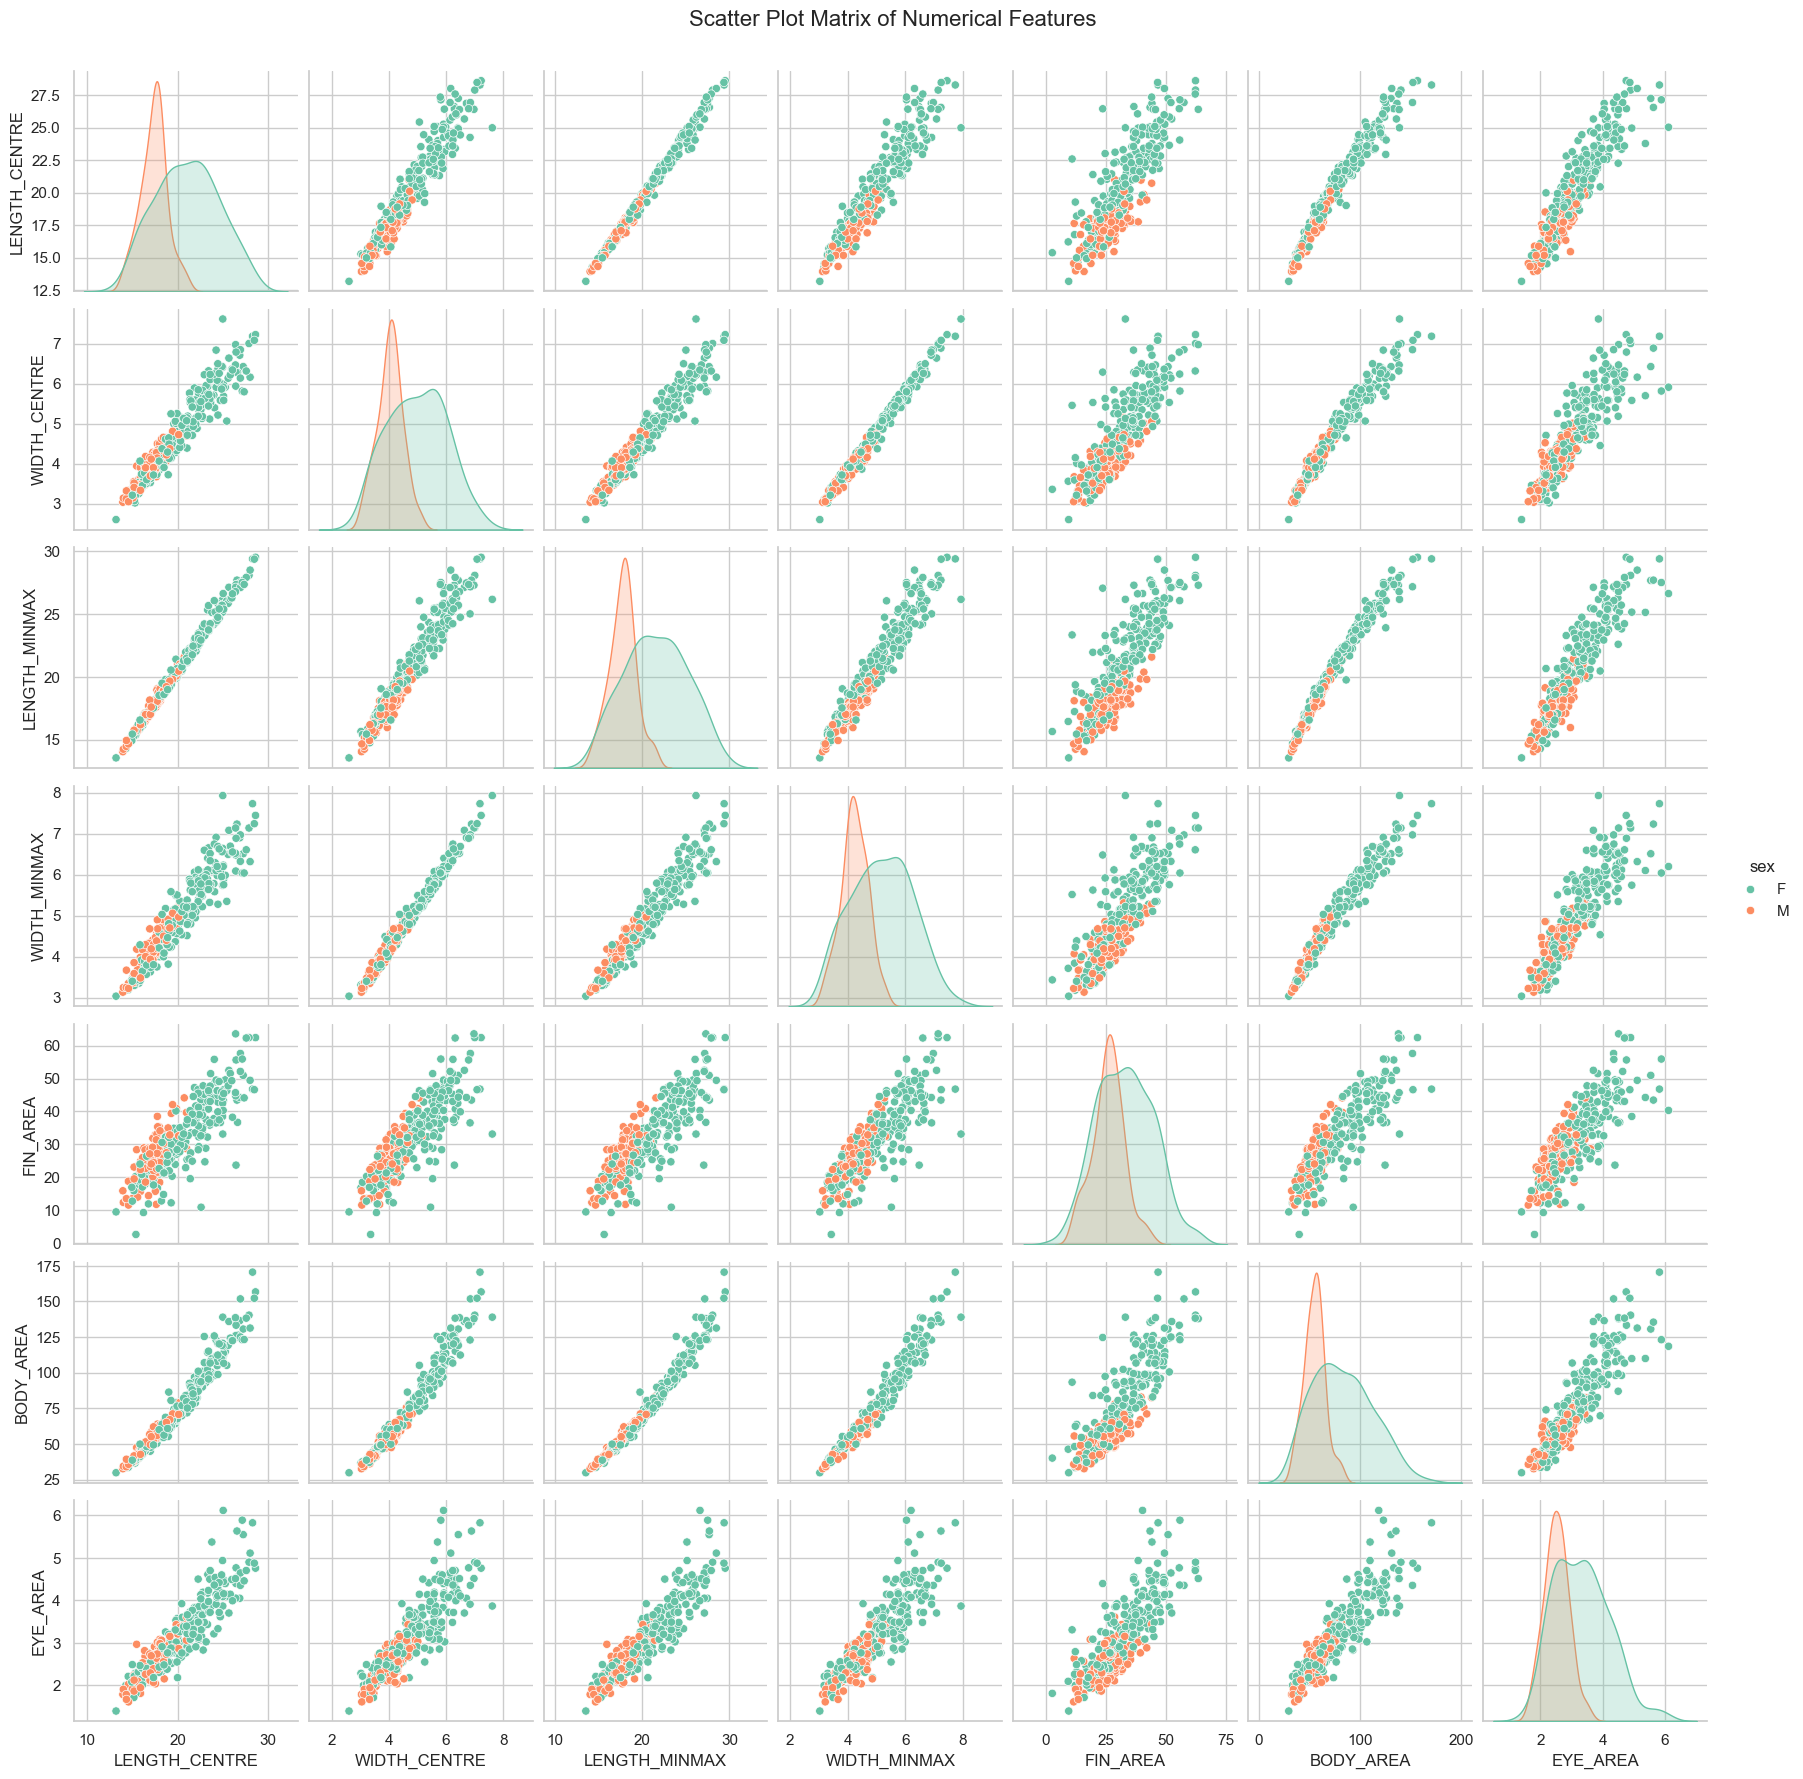

Number of females: 218


In [28]:
# List of numerical features
numerical_features = ['LENGTH_CENTRE', 'WIDTH_CENTRE', 'LENGTH_MINMAX', 'WIDTH_MINMAX', 
                      'FIN_AREA', 'BODY_AREA', 'EYE_AREA']

# Categorical feature for hue (e.g., 'sex')
hue_feature = 'sex'

# Create the pairplot
sns.pairplot(features_df[numerical_features + [hue_feature]], hue=hue_feature, palette='Set2', diag_kind='kde')

# Show the plot
plt.suptitle("Scatter Plot Matrix of Numerical Features", y=1.02, fontsize=16)
plt.show()

# Count the number of rows where sex is 'female'
female_count = features_df[features_df['sex'] == 'F'].shape[0]
# Print the result
print(f"Number of females: {female_count}")

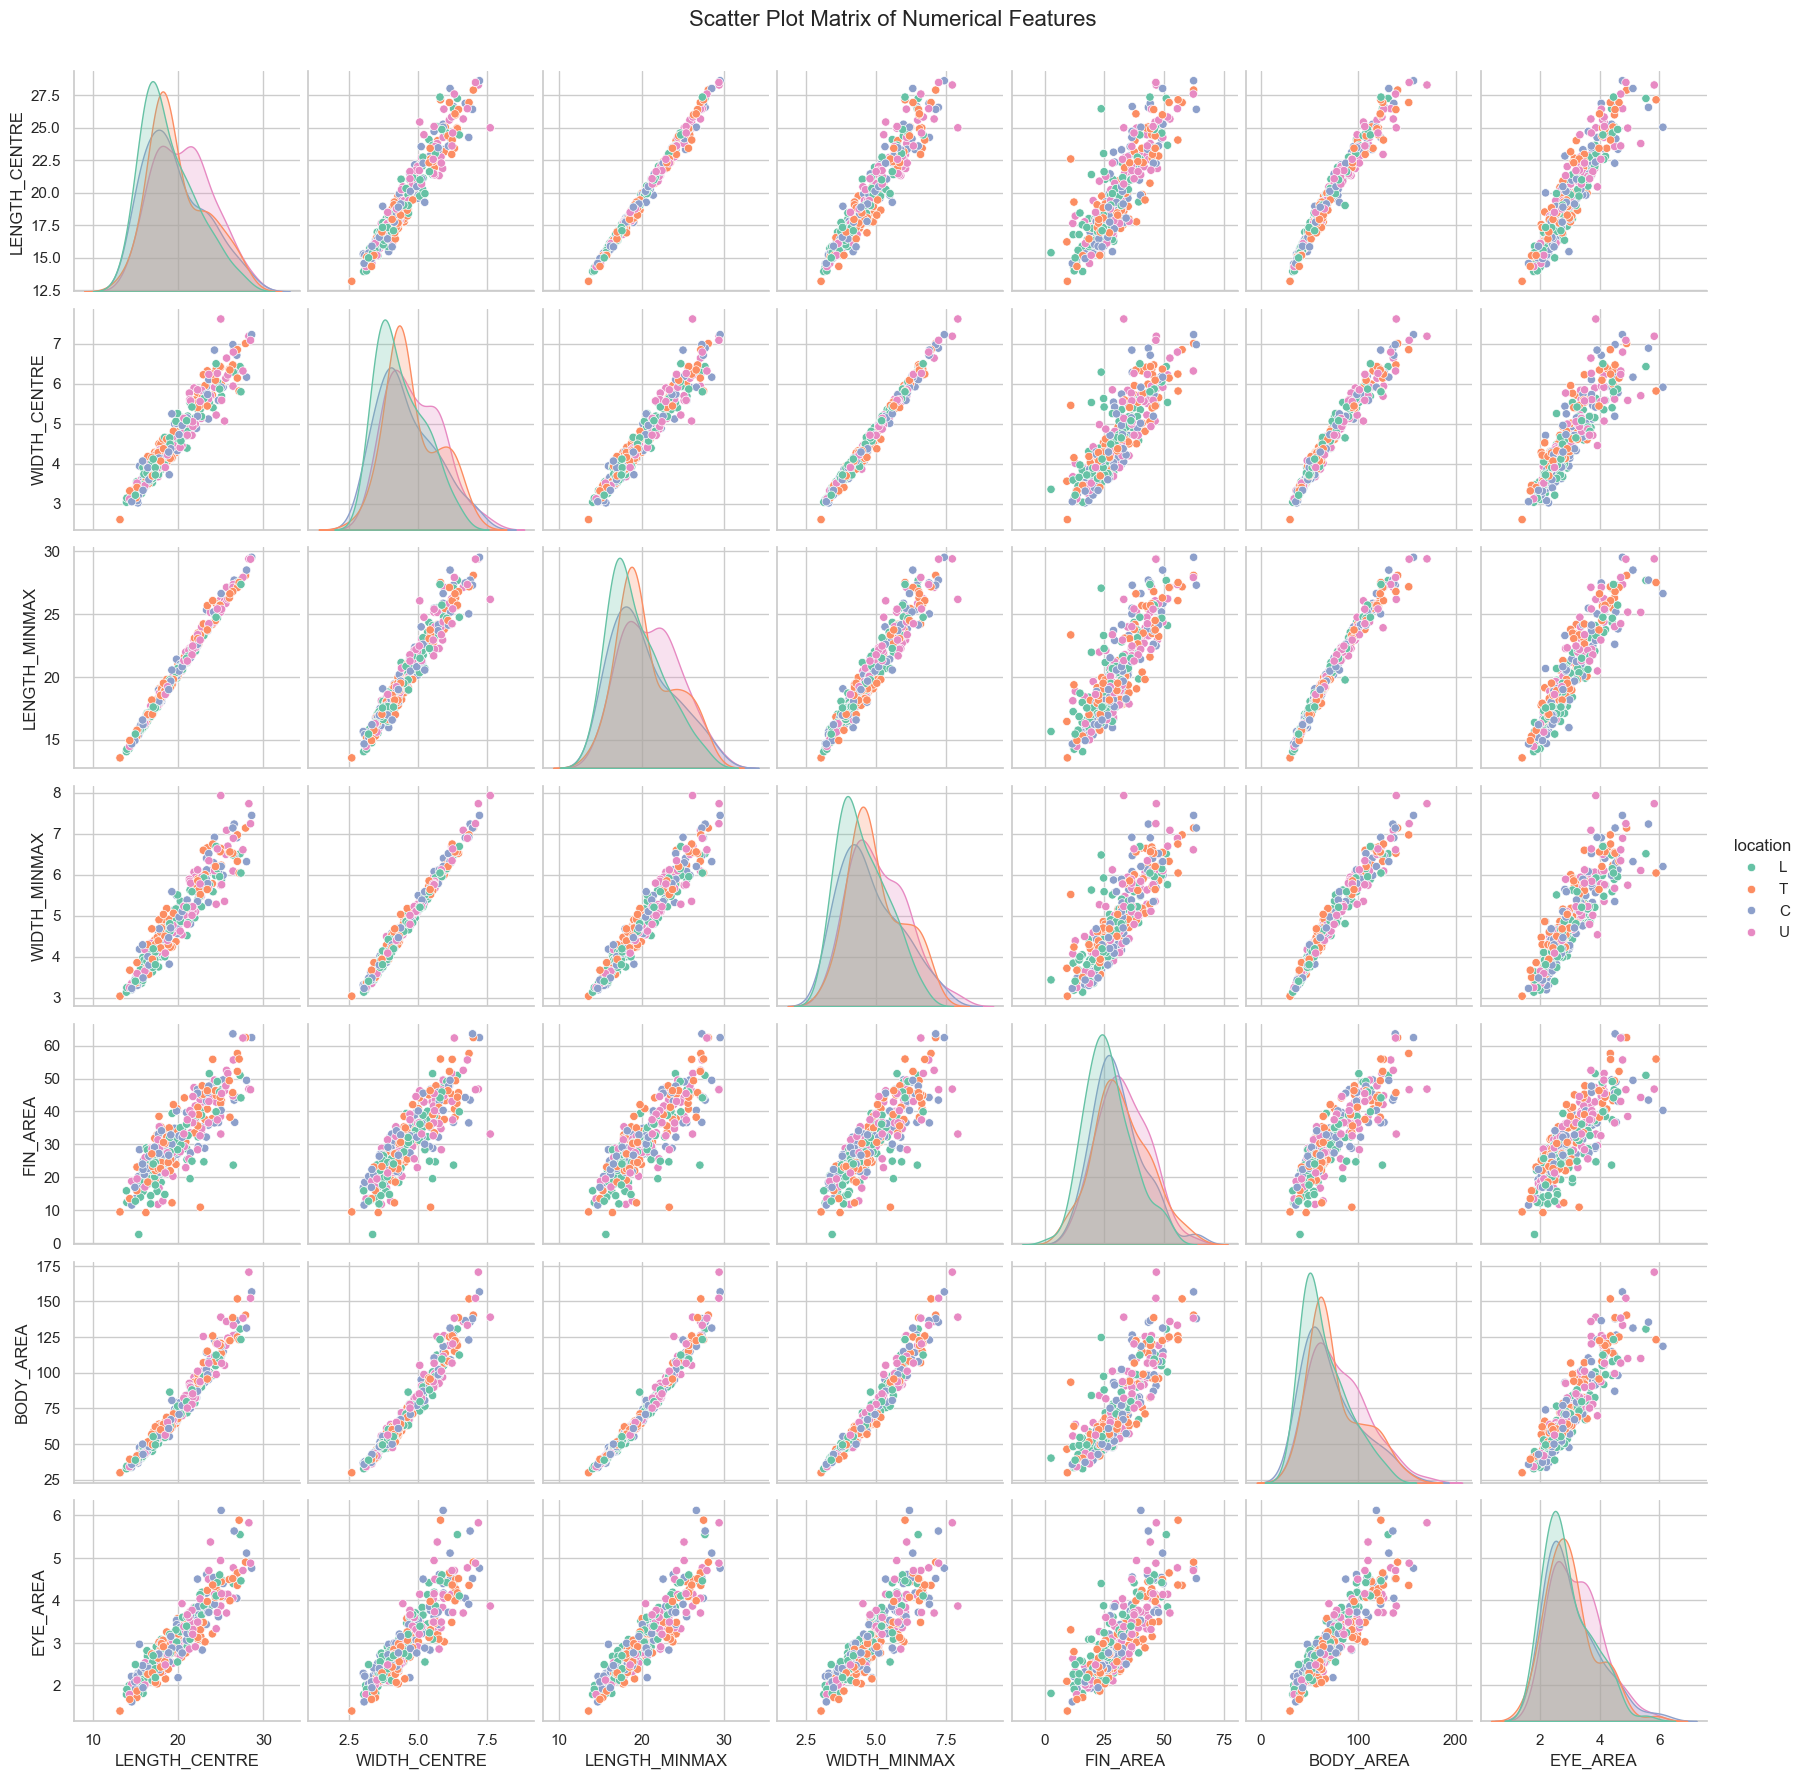

In [ ]:
# List of numerical features
numerical_features = ['LENGTH_CENTRE', 'WIDTH_CENTRE', 'LENGTH_MINMAX', 'WIDTH_MINMAX', 
                      'FIN_AREA', 'BODY_AREA', 'EYE_AREA']

# Categorical feature for hue (e.g., 'upstream')
hue_feature = 'location'

# Create the pairplot
sns.pairplot(features_df[numerical_features + [hue_feature]], hue=hue_feature, palette='Set2', diag_kind='kde')

# Show the plot
plt.suptitle("Scatter Plot Matrix of Numerical Features", y=1.02, fontsize=16)
plt.show()

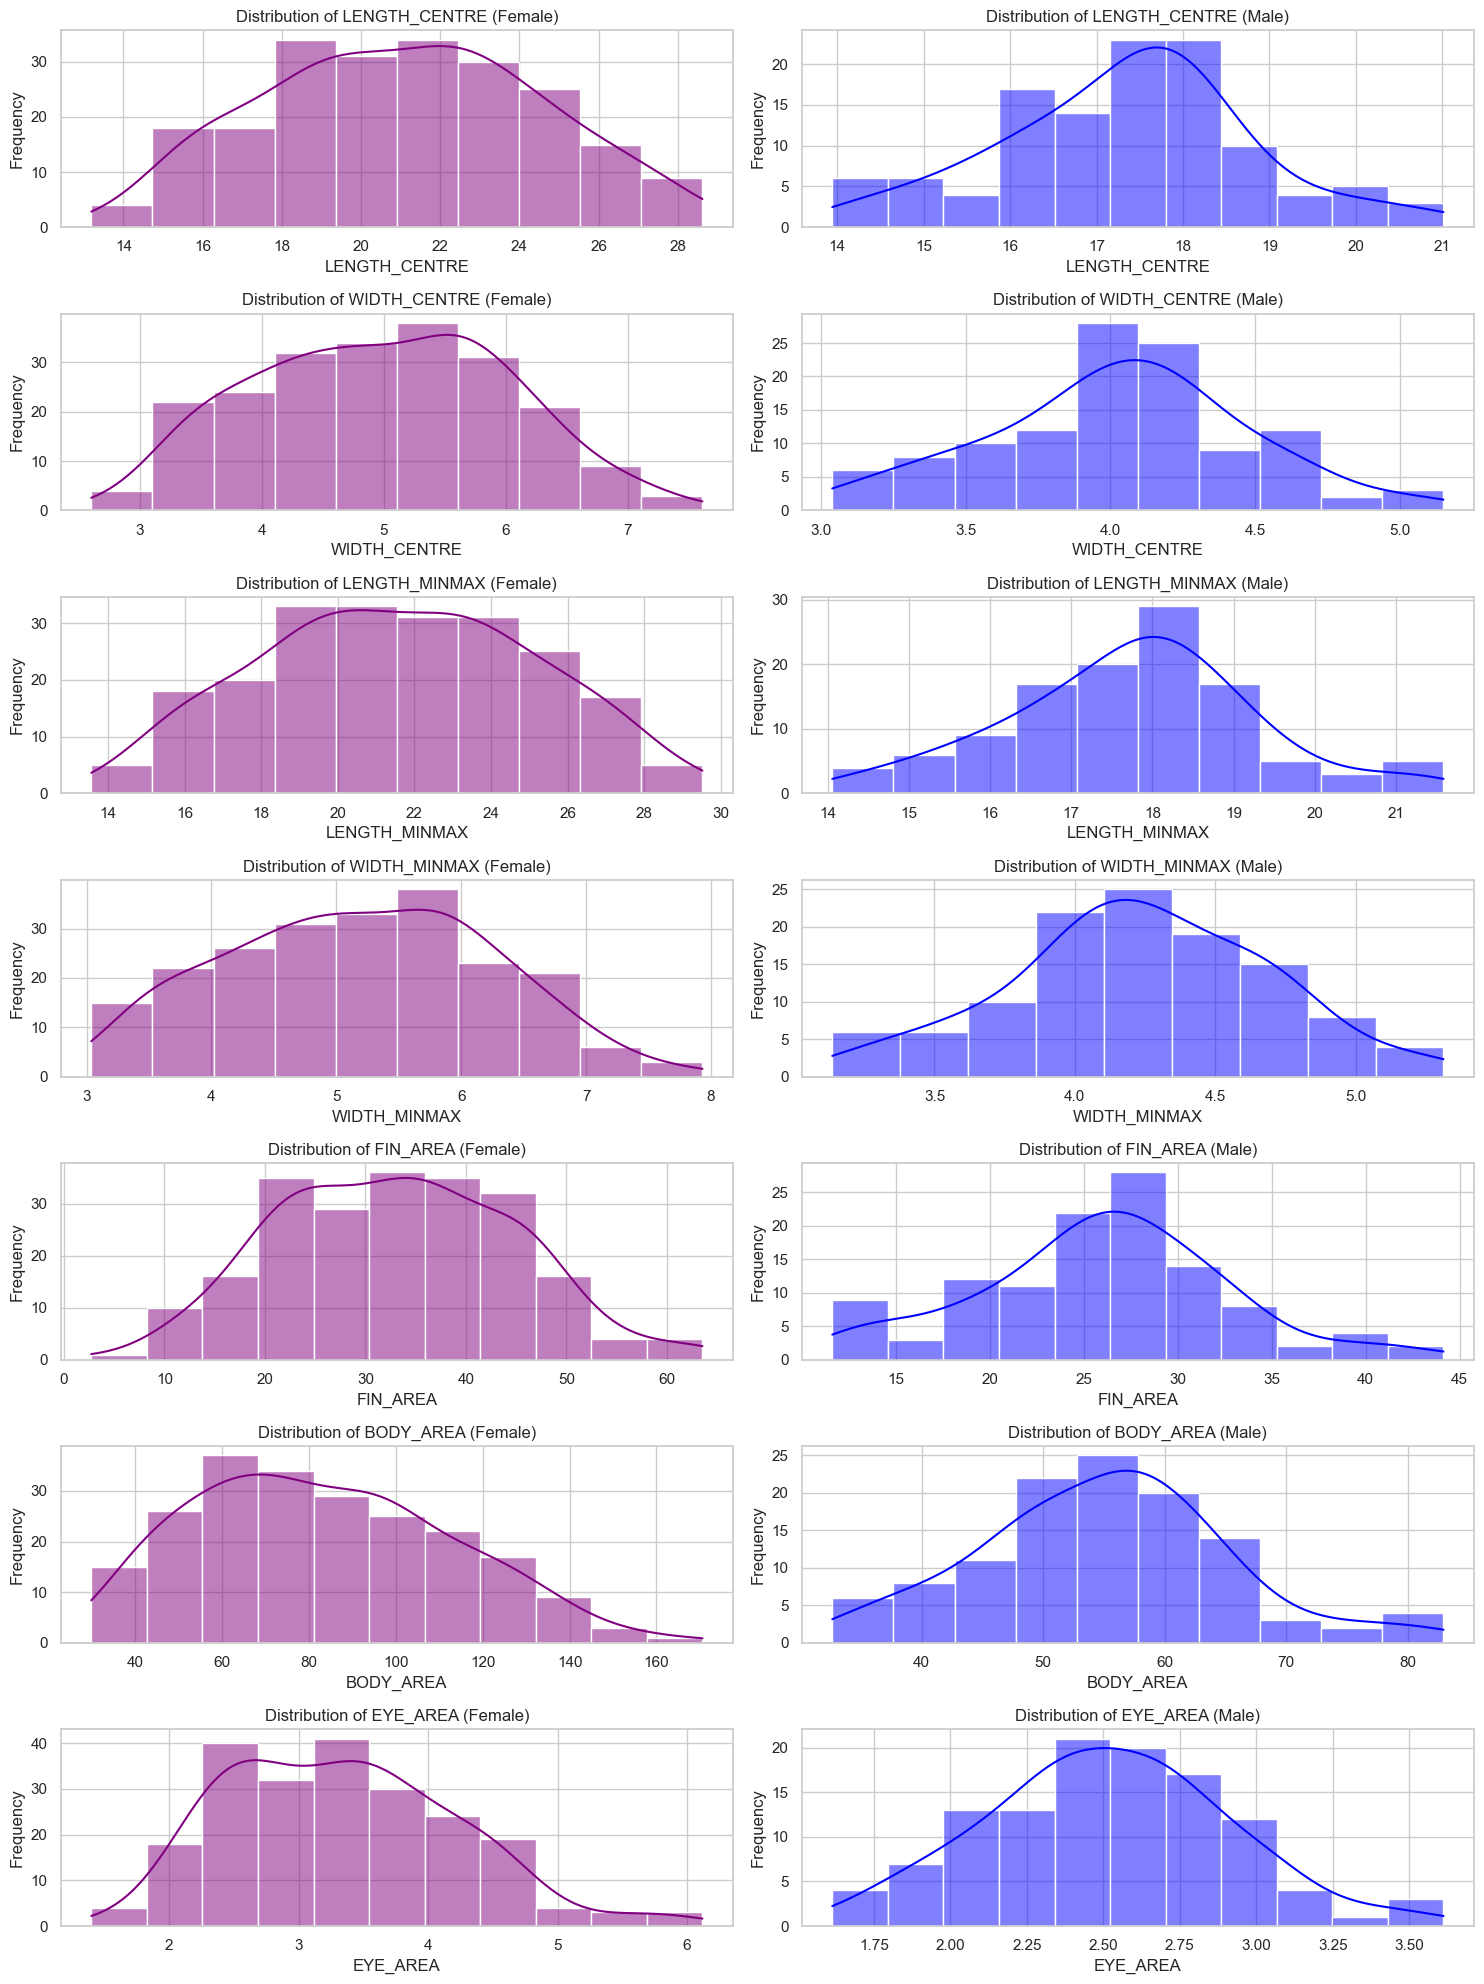

In [ ]:
# Set up the plot style
sns.set(style="whitegrid")

# Numerical columns to plot
numerical_columns = ['LENGTH_CENTRE', 'WIDTH_CENTRE', 'LENGTH_MINMAX', 'WIDTH_MINMAX', 'FIN_AREA', 'BODY_AREA', 'EYE_AREA']

# Create subplots
plt.figure(figsize=(15, 20))
for i, column in enumerate(numerical_columns, 1):
    # Plot for females
    plt.subplot(len(numerical_columns), 2, 2 * i - 1)  # Odd-indexed plots
    sns.histplot(features_df[features_df['sex'] == 'F'][column], kde=True, color="purple")
    plt.title(f"Distribution of {column} (Female)")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    
    # Plot for males
    plt.subplot(len(numerical_columns), 2, 2 * i)  # Even-indexed plots
    sns.histplot(features_df[features_df['sex'] == 'M'][column], kde=True, color="blue")
    plt.title(f"Distribution of {column} (Male)")
    plt.xlabel(column)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [49]:

numerical_columns = ['LENGTH_CENTRE', 'WIDTH_CENTRE', 'LENGTH_MINMAX', 'WIDTH_MINMAX', 'FIN_AREA', 'BODY_AREA', 'EYE_AREA']

# Calculate descriptive statistics
std_devs_by_sex = features_df.groupby('sex')[numerical_columns].std()
mean_by_sex = features_df.groupby('sex')[numerical_columns].mean()

# Print the standard deviations and means
#print("Standard Deviations by Sex:")
print(std_devs_by_sex)

#print("\nMeans by Sex:")
#print(mean_by_sex)


     LENGTH_CENTRE  WIDTH_CENTRE  LENGTH_MINMAX  WIDTH_MINMAX   FIN_AREA  \
sex                                                                        
F         3.467103      1.031288       3.591771      1.057187  11.737215   
M         1.462270      0.446120       1.532389      0.462359   6.610554   

     BODY_AREA  EYE_AREA  
sex                       
F    29.307201  0.889447  
M    10.246089  0.396719  


In [46]:
# t - tests between female and male for both 

import scipy.stats as stats

# Initialize a dictionary to store results
t_test_results = {}

# Perform t-tests for each feature
for column in numerical_columns:
    # Extract the data for males and females
    female_data = features_df[features_df['sex'] == 'F'][column]
    male_data = features_df[features_df['sex'] == 'M'][column]
    
    # Perform the t-test
    t_stat, p_value = stats.ttest_ind(female_data, male_data) 
    
    # Store the results in the dictionary
    t_test_results[column] = {'t-statistic': t_stat, 'p-value': p_value}

# Display the results
for column, results in t_test_results.items():
    print(f"Feature: {column}")
    print(f"  t-statistic: {results['t-statistic']:.3f}")
    print(f"  p-value: {results['p-value']}\n")

Feature: LENGTH_CENTRE
  t-statistic: 10.963
  p-value: 4.596231047191482e-24

Feature: WIDTH_CENTRE
  t-statistic: 9.430
  p-value: 7.434381435960473e-19

Feature: LENGTH_MINMAX
  t-statistic: 10.904
  p-value: 7.390079952663813e-24

Feature: WIDTH_MINMAX
  t-statistic: 9.150
  p-value: 5.999394876485388e-18

Feature: FIN_AREA
  t-statistic: 5.982
  p-value: 5.7186148910873145e-09

Feature: BODY_AREA
  t-statistic: 9.954
  p-value: 1.36132977718418e-20

Feature: EYE_AREA
  t-statistic: 9.377
  p-value: 1.1009982299847352e-18



# PCA Analysis and Clustering
Check for patterns in clustering by phenotypes and how it relates to time, sex, or location. 

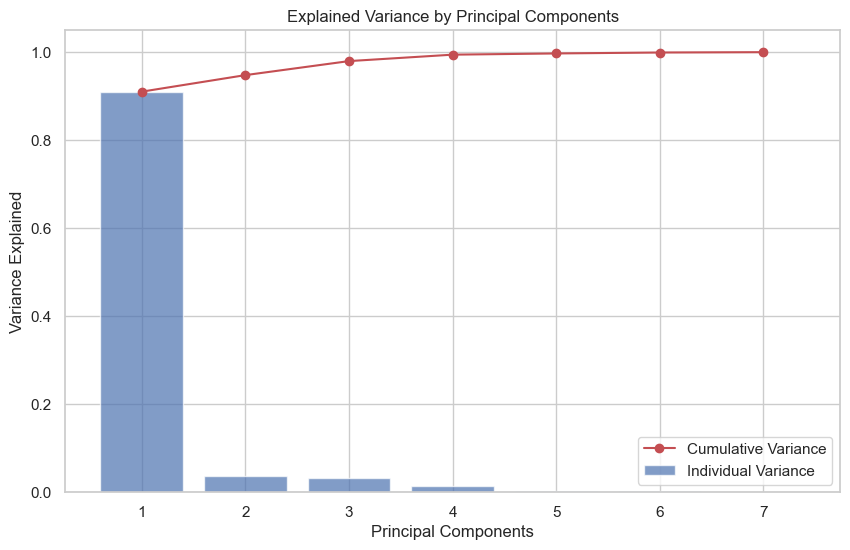

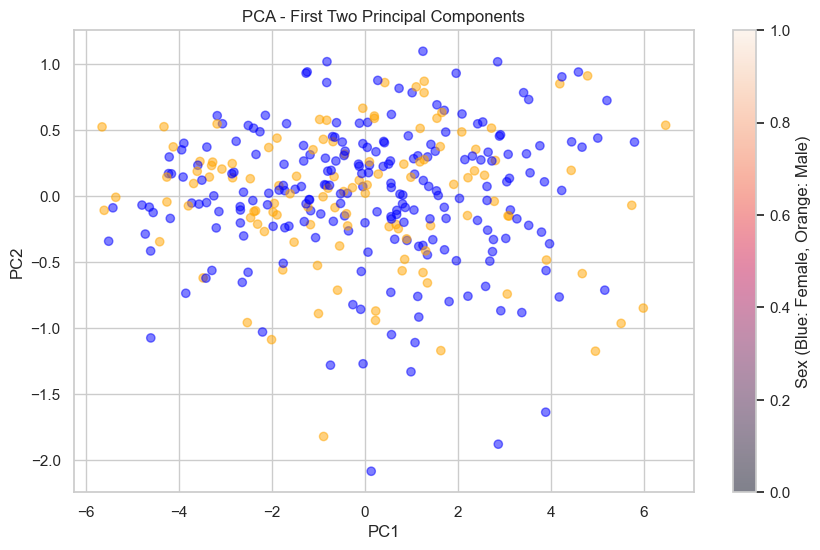

In [64]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Split the data into male and female subsets
female_data = features_df[features_df['sex'] == 'F']
male_data = features_df[features_df['sex'] == 'M']

# Standardize data for female group (using mean and std of female data)
female_scaled = female_data.copy()
for column in numerical_columns:
    mean_female = female_data[column].mean()
    std_female = female_data[column].std()
    female_scaled[column] = (female_data[column] - mean_female) / std_female

# Standardize data for male group (using mean and std of male data)
male_scaled = male_data.copy()
for column in numerical_columns:
    mean_male = male_data[column].mean()
    std_male = male_data[column].std()
    male_scaled[column] = (male_data[column] - mean_male) / std_male

# Combine the standardized data back into one dataframe
standardized_features_df = pd.concat([female_scaled, male_scaled])

# Combine the standardized data back into one dataframe
standardized_features_df = pd.concat([female_scaled, male_scaled])

# Perform PCA
pca = PCA()
X = standardized_features_df[numerical_columns].values  # Use all numerical columns for PCA
pca.fit(X)

# 1. Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# 2. Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, color='b', label='Individual Variance')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', color='r', label='Cumulative Variance')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.legend()
plt.show()

# 3. Plot the first two principal components
pca_result = pca.transform(X)  # Project data onto the principal components

# Scatter plot of the first two principal components
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=features_df['sex'].map({'F': 'blue', 'M': 'orange'}), alpha=0.5)
plt.title('PCA - First Two Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Sex (Blue: Female, Orange: Male)')
plt.show()


In [65]:
# Get the eigenvectors (loadings)
loadings = pca.components_

# Create a DataFrame for easier interpretation
loadings_df = pd.DataFrame(loadings, columns=numerical_columns)

# Display the loadings for each principal component
print("PCA Loadings:\n", loadings_df)

# To get the names of the features that contribute most to each principal component, 
# let's sort the loadings for each PC
for i in range(loadings.shape[0]):
    print(f"\nPrincipal Component {i+1} Contributions:")
    sorted_features = loadings_df.iloc[i].sort_values(ascending=False)
    print(sorted_features)

PCA Loadings:
    LENGTH_CENTRE  WIDTH_CENTRE  LENGTH_MINMAX  WIDTH_MINMAX  FIN_AREA  \
0       0.387155      0.385193       0.390574      0.384730  0.347789   
1      -0.154394     -0.169889      -0.175269     -0.179542  0.916037   
2       0.035111     -0.274409       0.006281     -0.290274 -0.191385   
3       0.571043     -0.449050       0.393224     -0.460852  0.051234   
4      -0.388257     -0.595094       0.001621      0.296577  0.021841   
5       0.163428     -0.419069       0.237627      0.631195 -0.009200   
6      -0.567008      0.126734       0.778203     -0.191675  0.010179   

   BODY_AREA  EYE_AREA  
0   0.390212  0.357700  
1  -0.202532  0.064825  
2  -0.126452  0.886877  
3   0.150883 -0.282600  
4   0.637270  0.023876  
5  -0.585181 -0.016649  
6  -0.139321 -0.024253  

Principal Component 1 Contributions:
LENGTH_MINMAX    0.390574
BODY_AREA        0.390212
LENGTH_CENTRE    0.387155
WIDTH_CENTRE     0.385193
WIDTH_MINMAX     0.384730
EYE_AREA         0.357700
FIN_AR

/var/folders/xq/0f0rp0jd0kd15xhg5qgnp0sr0000gp/T/ipykernel_44400/3976296309.py:16: UserWarning: The markers list has more values (4) than needed (2), which may not be intended.
  sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=features_df['sex'], style=features_df['cluster'], palette='Set1', markers=['o', 's', 'D', 'v'], s=100, alpha=0.7)


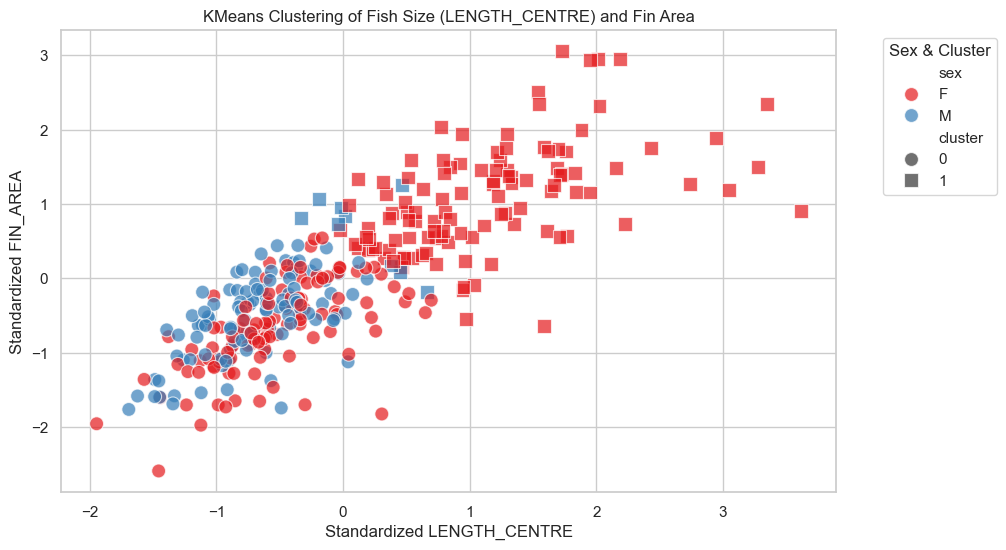

In [112]:
from sklearn.cluster import KMeans

# Select relevant columns for clustering: LENGTH_CENTRE and FIN_AREA
X = features_df[['EYE_AREA', 'FIN_AREA']]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=25)  # Choose the number of clusters
features_df['cluster'] = kmeans.fit_predict(X_scaled)

# Visualize the results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=features_df['sex'], style=features_df['cluster'], palette='Set1', markers=['o', 's', 'D', 'v'], s=100, alpha=0.7)

# Customize the plot
plt.title("KMeans Clustering of Fish Size (LENGTH_CENTRE) and Fin Area")
plt.xlabel('Standardized LENGTH_CENTRE')
plt.ylabel('Standardized FIN_AREA')
plt.legend(title='Sex & Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


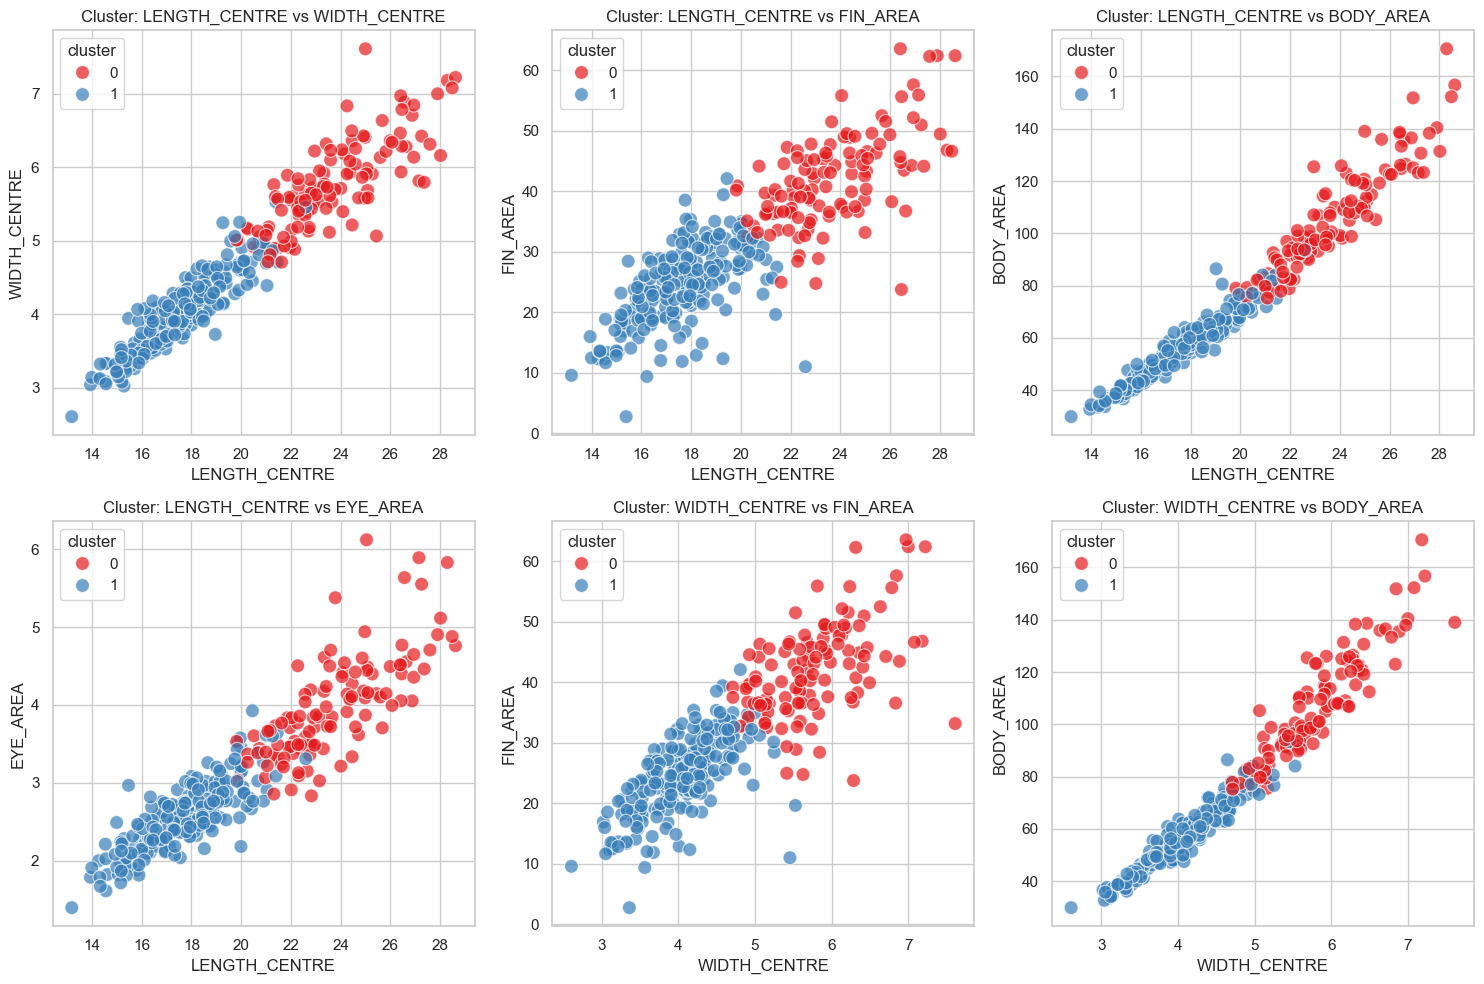

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'features_df' is your dataframe with relevant fish features
# Select numerical columns for clustering
numerical_columns = ['LENGTH_CENTRE', 'WIDTH_CENTRE', 'FIN_AREA', 'BODY_AREA', 'EYE_AREA']

# Drop rows with missing values (optional, depending on your dataset)
features_df = features_df.dropna(subset=numerical_columns)

# Extract features for clustering
X = features_df[numerical_columns]

# Standardize the features (important for clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)  # You can change the number of clusters
features_df['cluster'] = kmeans.fit_predict(X_scaled)

# Set up the figure for subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  # Adjust grid size as needed

# List of feature pairs for scatter plot
feature_pairs = [
    ('LENGTH_CENTRE', 'WIDTH_CENTRE'),
    ('LENGTH_CENTRE', 'FIN_AREA'),
    ('LENGTH_CENTRE', 'BODY_AREA'),
    ('LENGTH_CENTRE', 'EYE_AREA'),
    ('WIDTH_CENTRE', 'FIN_AREA'),
    ('WIDTH_CENTRE', 'BODY_AREA')
]

# Flatten axes for easier iteration
axes = axes.flatten()

# Loop over the feature pairs and axes to create scatter plots
for i, (feature1, feature2) in enumerate(feature_pairs):
    ax = axes[i]
    
    # Scatter plot for each pair of features, colored by cluster
    sns.scatterplot(x=features_df[feature1], y=features_df[feature2], hue=features_df['cluster'], palette='Set1', ax=ax, s=100, alpha=0.7, markers='o')

    # Customize each subplot
    ax.set_title(f"Cluster: {feature1} vs {feature2}")
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [87]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# 1. Silhouette Score
sil_score = silhouette_score(X_scaled, features_df['cluster'])
print(f"Silhouette Score: {sil_score}")

# 2. Davies-Bouldin Index
db_score = davies_bouldin_score(X_scaled, features_df['cluster'])
print(f"Davies-Bouldin Index: {db_score}")

Silhouette Score: 0.5630703961670811
Davies-Bouldin Index: 0.6290714557918292


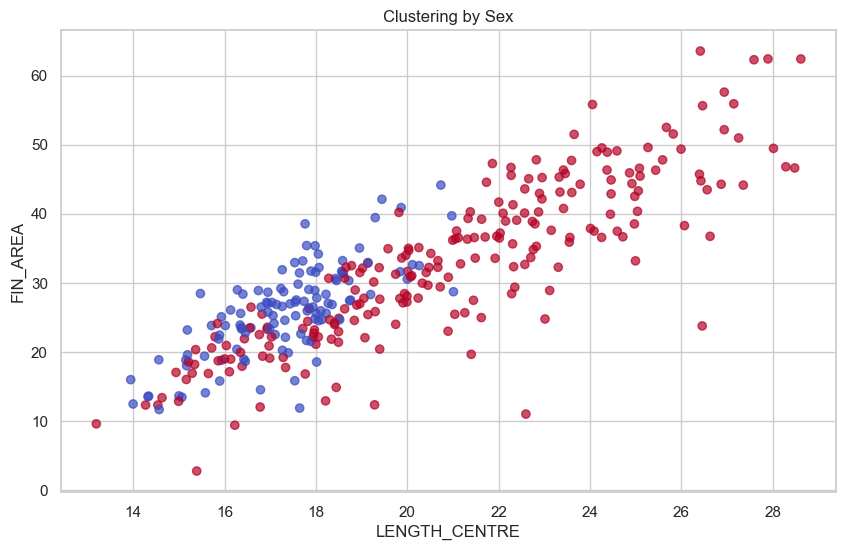

In [113]:
# Plot the clusters colored by sex (for comparison)
plt.figure(figsize=(10, 6))
plt.scatter(features_df['LENGTH_CENTRE'], features_df['FIN_AREA'], c=features_df['sex'].map({'M': 0, 'F': 1}), cmap='coolwarm', marker='o', alpha=0.7)
plt.title('Clustering by Sex')
plt.xlabel('LENGTH_CENTRE')
plt.ylabel('FIN_AREA')
plt.show()

# Regression Analysis

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Select relevant columns for clustering: LENGTH_CENTRE and FIN_AREA
X = features_df[['WIDTH_CENTRE','WIDTH_MINMAX','FIN_AREA','BODY_AREA','EYE_AREA']]
Y = features_df[['LENGTH_CENTRE']]

model = LinearRegression()

model.fit(X,Y)

#coeff_parameter = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])

print(model.coef_)


[[ 1.25312651 -1.44754888  0.01355306  0.10502158  0.66294725]]


In [ ]:
x_test = features_df[['WIDTH_CENTRE','WIDTH_MINMAX','FIN_AREA','BODY_AREA','EYE_AREA']]
y_test = features_df[['LENGTH_CENTRE']]

model.predict(x_test)


array([[21.4898632 ],
       [24.83809359],
       [15.98946163],
       [18.46564674],
       [16.00224648],
       [19.62684952],
       [27.54478457],
       [15.91851383],
       [19.8014338 ],
       [20.7371894 ],
       [26.49978371],
       [23.24346447],
       [22.49666709],
       [24.84827272],
       [25.38867465],
       [17.7847196 ],
       [16.74391397],
       [25.21330897],
       [16.90706679],
       [18.2646858 ],
       [18.98196708],
       [15.97477275],
       [22.66560044],
       [21.61100981],
       [17.45788887],
       [18.49774676],
       [26.13272513],
       [24.36310996],
       [17.05762554],
       [24.7765443 ],
       [18.01648539],
       [23.23295358],
       [15.40885872],
       [22.15026363],
       [23.85464793],
       [31.04960388],
       [17.45208309],
       [22.79789322],
       [19.28207136],
       [17.51823901],
       [18.7780755 ],
       [18.14908085],
       [15.2371512 ],
       [19.00264884],
       [22.29878472],
       [18

In [126]:
y_test

,LENGTH_CENTRE
0,21.1185
1,25.0850
2,15.9320
3,18.5020
4,15.1515
...,...
328,18.4940
329,24.6000
330,21.0800
331,23.4200
